In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

I did think using tf-idf or Bow wouldn't be a good choice for clustering as it would not caputure the main essence of each instrument/mood of the song/style of the song rather they would just treat them as three usual words.

But I didn't find much luck and got to know I was wrong.

Even after doing a bit Feature Engineering and adding a few more columns from existing columns my metrics didn't improve much.

In [4]:
df=pd.read_csv("TASK2_dataset.csv")
df = df.rename(columns={'keyword_1': 'instrument', 'keyword_2': 'mood','keyword_3':'style'})

In [5]:
df

,song_id,instrument,mood,style,genre
0,74,guitar,happy,distorted,rock
1,103,brass,energetic,melodic,classical
2,201,banjo,happy,acoustic,country
3,194,synth,energetic,heavy,hip-hop
4,184,synth,energetic,slow,hip-hop
...,...,...,...,...,...
142,195,synth,angry,melodic,hip-hop
143,7,guitar,energetic,fast,pop
144,14,guitar,happy,rhythmic,pop
145,36,synth,mellow,danceable,pop


Firstly let me define the functions required in this task

kMeans Clustering
It randomly finds k elements and assigns them clusters.
then all elements are assigned to a cluster based on nearest distance.
Now center of each cluster is calculated called centroid,now again all elements are assigned to a cluster near to each centroid.

In [7]:
def kmeans(data, n_clusters):
    np.random.seed(42)

    n_samples, n_features = data.shape

    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    centroids = np.random.uniform(low=min_vals, high=max_vals, size=(n_clusters, n_features))

    labels = np.zeros(n_samples, dtype=int)

    for _ in range(300):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2) 
        new_labels = np.argmin(distances, axis=1)

        if np.array_equal(new_labels, labels):
            break

        labels = new_labels

        for j in range(n_clusters):
            cluster_points = data[labels == j]
            if len(cluster_points) > 0: 
                centroids[j] = np.mean(cluster_points, axis=0)

    return labels, centroids

PCA (Principal Componenet Analysis) 

Firstly the data is standardised by using a scaling algorithm called standard scaler 
= (x - mean) / standard_deviation

Then a covariance matrix is calculated which tells you the relationships between different variables.
Next eigenvectors and eigenvalues are calculated eigenvectors represent the direction of maximum variance while the eigenvalues represent the amount of eigenvectors.Then the imaginary parts of eigenvectorsa nd eigenvalues are discarded.Next the eigenvectors i.e. principal componenets are arranged in a descending order by eigenvalues.Then the number of principal components which are needed to be kept are kept descending order wise.Further explained variance ratio is calculated which tells you that how much variance in the data is given by each principal component.

In [9]:
def pca(data, n_comp):
    data = data.values

    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    data = (data - mean) / std

    covariance_matrix = np.cov(data, rowvar=False)

    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    eigenvectors = eigenvectors[:, :n_comp]
    pca_data = np.dot(data, eigenvectors)

    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    return pca_data, explained_variance_ratio

Silhouette Score is calculated in this function,X conatains all the features.next a_i and b_i are calculated.

a_i denotes the average distance between data point and all other points in the same cluster.b_i denotes the average distance between the data point and all other points in the nearest other cluster.then s_i Silhouette Score is calculated (b_i - a_i) / max(a_i, b_i).

In [11]:
def silhouette_score(X, labels):
    X = np.asarray(X)
    labels = np.asarray(labels)
    n_samples = len(X)
    n_clusters = len(np.unique(labels))

    silhouette_scores = []

    for i in range(n_samples):
        a_i = 0 
        b_i = np.inf  

        cluster_i = labels[i]

        cluster_i_indices = np.where(labels == cluster_i)[0]
        if len(cluster_i_indices) > 1:
          distances_i_cluster = np.linalg.norm(X[i] - X[cluster_i_indices], axis=1)
          a_i = np.mean(distances_i_cluster[cluster_i_indices!=i]) 

        for j in range(n_clusters):
            if j != cluster_i:
                cluster_j_indices = np.where(labels == j)[0]
                distances_i_cluster_j = np.linalg.norm(X[i] - X[cluster_j_indices], axis=1)
                b_i = min(b_i, np.mean(distances_i_cluster_j))

        if b_i == np.inf:
          s_i = 0
        else:
          s_i = (b_i - a_i) / max(a_i, b_i)

        silhouette_scores.append(s_i)

    return np.mean(silhouette_scores)

Here firstly the comb function calculates the combination n!/(n-r)!r!

Now in ARI function firstly the labels are converted into numpy arrays.Then a contingency table is created which represents the relationships between the true and predicted labels,the rows and columns each represent one of the two types of labels while the cells represent the frequencies of observations that fall into the intersection between the row and column.now a and d are calculated a represents the number of pairs of samples that are in the same cluster in both the predicted and the true label whereas d represents the number of pairs of samples that are in different clusters in both the true  and predicted label.Now the Rand Index is calculated

ri = (a + d) / comb(n, 2) if comb(n,2) != 0 else 0

now the expected rand index is calculated if the clusterings were random 

expected_ri = (contingency_table.sum(axis=0) @ contingency_table.sum(axis=1)) / comb(n, 2)**2 if comb(n,2) != 0 else 0

now the adjusted rand index is calculated 
ari = (ri - expected_ri) / (1 - expected_ri) if (1-expected_ri) !=0 else 0

In [13]:
def comb(n, k):
    if k == 0 or k == n:
        return 1
    result = 1
    for i in range(1, k + 1):
        result = result * (n - i + 1) // i  
    return result

def adjusted_rand_index(labels_true, labels_pred):
    labels_true = np.asarray(labels_true)
    labels_pred = np.asarray(labels_pred)

    n_samples = len(labels_true)

    contingency_table = pd.crosstab(labels_true, labels_pred)
    a = 0
    d = 0
    for i in range(len(contingency_table.index)):
        for j in range(len(contingency_table.columns)):
            nij = contingency_table.iloc[i, j]
            a += comb(nij, 2) if nij >=2 else 0 
    
    for i in range(len(contingency_table.index)):
        ai = contingency_table.iloc[i,:].sum()
        d += comb(ai, 2) if ai >=2 else 0
    d -= a

    for j in range(len(contingency_table.columns)):
        bj = contingency_table.iloc[:,j].sum()
        d += comb(bj, 2) if bj >=2 else 0
    d -= a

    n = n_samples
    ri = (a + d) / comb(n, 2) if comb(n,2) != 0 else 0
    expected_ri = (contingency_table.sum(axis=0) @ contingency_table.sum(axis=1)) / comb(n, 2)**2 if comb(n,2) != 0 else 0 
    ari = (ri - expected_ri) / (1 - expected_ri) if (1-expected_ri) !=0 else 0

    return ari

BOW(Bag of Words) is technique in which all the unique keywords here in this dataframe are put as columns in a dataframe and each song as each row where the number in each column denotes how many times the word is there for each song.

In [15]:
def Bow(df):
    all_words = []
    for text in df["combined"]:
        words = text.split()
        all_words.extend(words)

    vocab = sorted(list(set(all_words)))

    dtm = pd.DataFrame(0, index=range(len(df)), columns=vocab)

    for i, text in df["combined"].items():
        words = text.split()
        for word in words:
            dtm.loc[i, word] += 1

    return dtm

TfIdf(Term frequency Inverse Document Frequency) vectorizer also plots a dataframe similar to bag of words but applies a function on it.

TF=(total terms present in doc/total tokens in doc)
IDF=log(Total docs/number of docs term t is present in)

function is Tf*Idf

In [17]:
def tfidf(df):
    dtm = Bow(df)
    vocab = dtm.columns.tolist()

    tf = dtm / 3

    freq = (dtm > 0).sum(axis=0)
    idf = np.log(len(df) / freq)  

    tfidf_matrix = tf * idf
    tfidf_df = pd.DataFrame(tfidf_matrix, index=dtm.index, columns=vocab)
    return tfidf_df

I am now using BOW to vectorize words

In [19]:
df['combined'] = df['mood'] + ' ' + df['style'] + ' ' + df['instrument']
dtm1=Bow(df)
dtm1
columns1=dtm1.columns

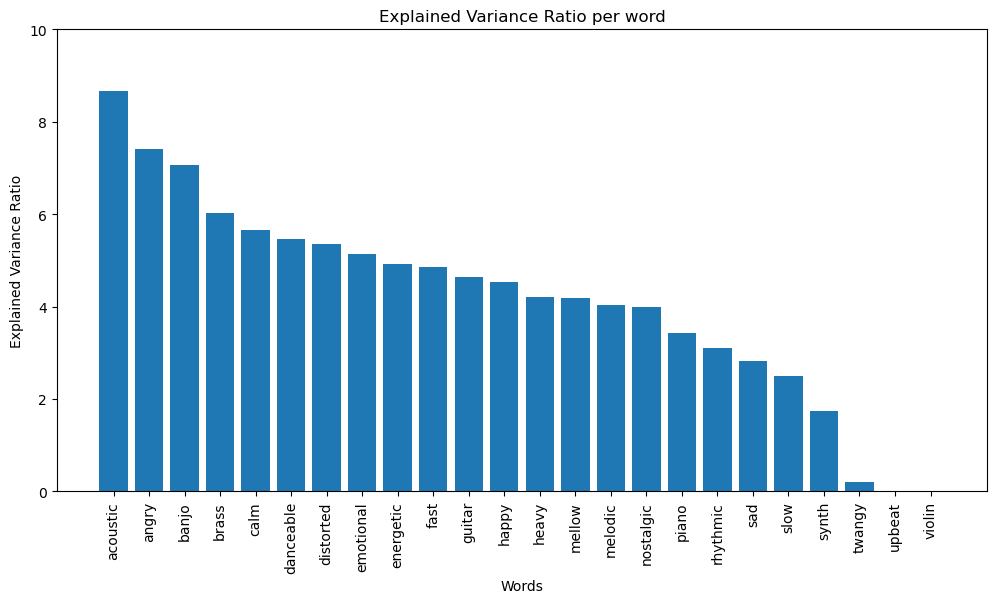

In [20]:
dtm1,var1=pca(dtm1,n_comp=2)

n_components_plotted = len(var1)

plt.figure(figsize=(12, 6))
plt.bar(columns1,var1*100)
plt.xlabel("Words")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio per word")
plt.xticks(rotation=90) 
plt.ylim(0, 10) 
plt.show()

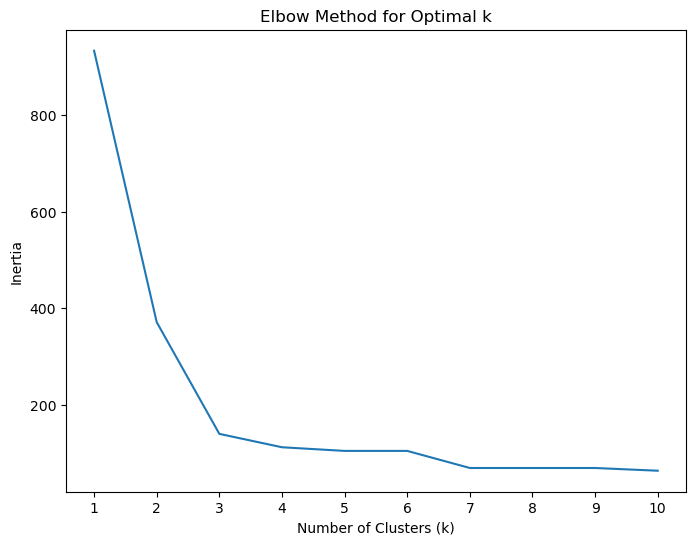

In [21]:
inertia_values = []

for k in range(1, 11): 
    labels, centr1 = kmeans(dtm1, k) 
    distances = np.linalg.norm(dtm1[:, np.newaxis] - centr1, axis=2)
    min_distances = np.min(distances, axis=1)
    inertia = np.sum(min_distances**2)
    inertia_values.append(inertia)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia_values)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.xticks(range(1, 11)) 
plt.show()

From the above graph we can see that the best number of clusters is 3

In [23]:
dtm_pca1,centr1=kmeans(dtm1,5)

In [24]:
df["genre_numerical"], _ = pd.factorize(df["genre"])
adjusted_rand_index1=adjusted_rand_index(dtm_pca1,df["genre_numerical"])
adjusted_rand_index1

0.39024785740910006

In [25]:
silhouette_score1=silhouette_score(dtm1,dtm_pca1)
silhouette_score1

0.4785827895891898

I am now using tfidf vectorizer to vectorize words

In [27]:
dtm2=tfidf(df)
dtm2
columns2=dtm2.columns

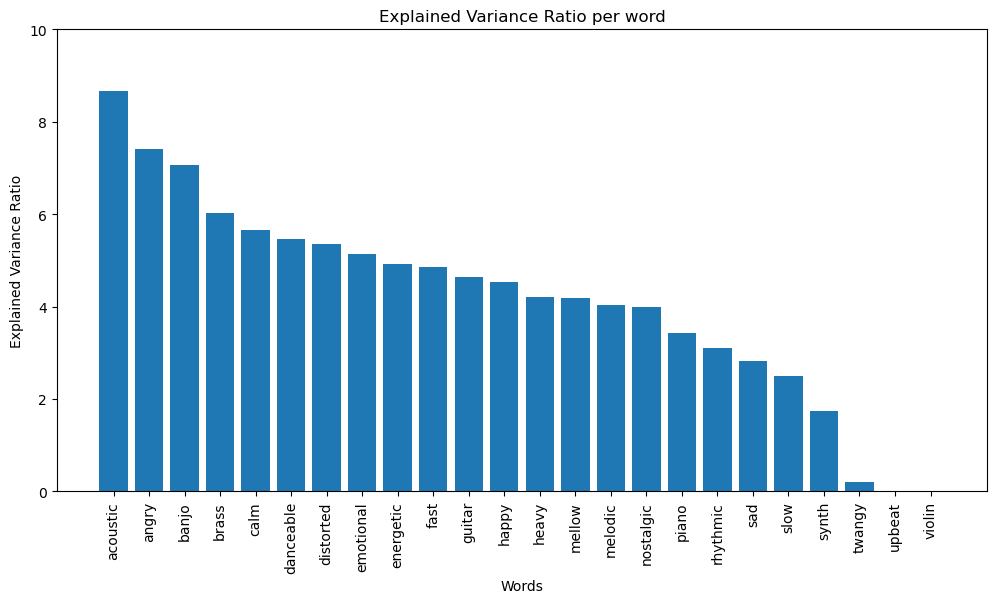

In [28]:
dtm2,var2=pca(dtm2,n_comp=2)

n_components_plotted = len(var2)

plt.figure(figsize=(12, 6))
plt.bar(columns2,var2*100)
plt.xlabel("Words")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio per word")
plt.xticks(rotation=90) 
plt.ylim(0, 10) 
plt.show()

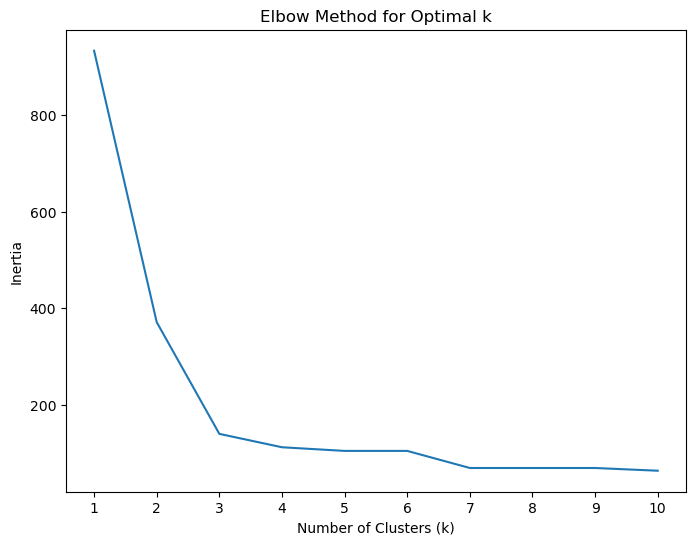

In [29]:
inertia_values = []

for k in range(1, 11): 
    labels, centr2 = kmeans(dtm2, k) 
    distances = np.linalg.norm(dtm2[:, np.newaxis] - centr2, axis=2)
    min_distances = np.min(distances, axis=1)
    inertia = np.sum(min_distances**2)
    inertia_values.append(inertia)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia_values)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.xticks(range(1, 11)) 
plt.show()

From the above graph we can see that the best number of clusters is 3

In [31]:
dtm_pca2,centr2=kmeans(dtm2,5)

In [32]:
adjusted_rand_index2=adjusted_rand_index(dtm_pca2,df["genre_numerical"])
adjusted_rand_index2

0.39024785740910006

In [33]:
silhouette_score2=silhouette_score(dtm2,dtm_pca2)
silhouette_score2

0.47858278958919126

Now I am adding a few features for each column and trying if this would improve the performance.

First of all the instrument

In [35]:
df["instrument"].value_counts()

instrument
guitar    65
synth     43
piano     12
brass     11
violin    10
banjo      6
Name: count, dtype: int64

In [36]:
instrument=pd.read_csv("instrument.csv")

In [37]:
instrument

,instrument,freq_min,freq_max,dynamic_range,loudness_min,loudness_max,pitch_min,pitch_max
0,guitar,82.0,1.300,80,85,95,82.0,1.300
1,brass,165.0,15.000,90,90,120,165.0,2.093
2,banjo,294.0,0.588,20,95,105,196.0,0.784
3,synth,20.0,20.000,105,40,120,27.5,4.186
4,violin,196.0,20.000,30,75,100,196.0,2.637
5,piano,27.5,4.200,105,60,105,27.5,4.186


Here I have broken down the frequency range into freq_min and freq_max similarly loudness and pitch have also been broken down

From the below research I took a few important features for each mood

https://sites.tufts.edu/eeseniordesignhandbook/2015/music-mood-classification/

I took the mean for all features for the above moods

In [41]:
mood=pd.read_csv("mood.csv")

In [42]:
mood

,mood,mean_intensity,mean_timbre,mean_pitch,mean_rhythm
0,happy,0.20550,0.44180,967.470,209.010
1,mellow,0.10700,0.15815,570.070,86.980
2,energetic,0.45640,0.31900,381.650,163.140
3,sad,0.22450,0.15720,95.654,137.230
4,angry,0.20830,0.34090,182.690,149.630
5,calm,0.06580,0.10490,383.490,72.230
6,emotional,0.27075,0.29185,353.797,157.465
7,upbeat,0.45640,0.31900,381.650,163.140
8,nostalgic,0.14820,0.21140,756.650,101.730


In [43]:
style=pd.read_csv("style2.csv")

Here also I have broken down the features containing range into min and max.

In [45]:
style

,style,Tempo (BPM)_min,Tempo (BPM)_max,Spectral Centroid (Hz)_min,Spectral Centroid (Hz)_max,RMS Energy_min,RMS Energy_max,Danceability_min,Danceability_max,Acousticness_min,...,Dissonance_min,Dissonance_max,Zero-Crossing Rate_min,Zero-Crossing Rate_max,Low-Freq Energy_min,Low-Freq Energy_max,HNR_min,HNR_max,Spectral Rolloff (Hz),Spectral Rolloff (Hz).1
0,distorted,80,160,1.5,4.0,0.90,1.0,0.30,0.50,0.10,...,0.8,0.90,0.85,0.95,0.40,0.60,0.1,0.30,6.0,10.0
1,melodic,60,120,0.8,2.0,0.40,0.7,0.40,0.60,0.60,...,0.1,0.30,0.20,0.40,0.10,0.30,0.7,0.90,3.0,5.0
2,acoustic,50,110,0.5,2.5,0.30,0.6,0.30,0.50,0.90,...,0.1,0.20,0.10,0.30,0.10,0.20,0.8,1.00,2.0,4.0
3,heavy,70,180,0.2,0.8,0.95,1.0,0.40,0.60,0.05,...,0.7,0.85,0.60,0.80,0.85,0.95,0.2,0.40,0.5,1.5
4,slow,40,70,0.3,1.0,0.20,0.4,0.10,0.30,0.70,...,0.2,0.40,0.10,0.25,0.30,0.50,0.6,0.80,1.0,2.0
5,upbeat,120,160,2.0,5.0,0.70,0.9,0.85,0.95,0.30,...,0.3,0.50,0.50,0.70,0.20,0.40,0.5,0.70,8.0,12.0
6,rhythmic,90,140,1.0,3.0,0.60,0.8,0.70,0.90,0.20,...,0.4,0.60,0.40,0.60,0.50,0.70,0.4,0.60,4.0,7.0
7,twangy,80,120,3.0,8.0,0.50,0.7,0.50,0.70,0.80,...,0.2,0.35,0.30,0.50,0.10,0.30,0.7,0.85,10.0,15.0
8,fast,160,220,1.0,4.0,0.80,1.0,0.60,0.80,0.10,...,0.6,0.80,0.70,0.90,0.60,0.80,0.3,0.50,6.0,10.0
9,danceable,115,130,2.0,5.0,0.70,0.9,0.90,1.00,0.20,...,0.4,0.60,0.60,0.80,0.40,0.60,0.5,0.70,8.0,12.0


In [46]:
df=df.drop(["combined","genre_numerical"],axis=1)

In [47]:
merged_df1 = pd.merge(df, style, on='style',how='left')
merged_df1 = pd.merge(merged_df1, mood, on='mood',how='left')
merged_df1 = pd.merge(merged_df1, instrument, on='instrument',how='left')

In [48]:
merged_df1=merged_df1.drop(["instrument","mood","genre","style"],axis=1)
merged_df1=merged_df1.set_index("song_id")

In [49]:
merged_df1

,Tempo (BPM)_min,Tempo (BPM)_max,Spectral Centroid (Hz)_min,Spectral Centroid (Hz)_max,RMS Energy_min,RMS Energy_max,Danceability_min,Danceability_max,Acousticness_min,Acousticness_max,...,mean_timbre,mean_pitch,mean_rhythm,freq_min,freq_max,dynamic_range,loudness_min,loudness_max,pitch_min,pitch_max
song_id,,,,,,,,,,,,,,,,,,,,,
74,80,160,1.5,4.0,0.90,1.0,0.3,0.5,0.10,0.2,...,0.44180,967.470,209.010,82.0,1.300,80,85,95,82.0,1.300
103,60,120,0.8,2.0,0.40,0.7,0.4,0.6,0.60,0.8,...,0.31900,381.650,163.140,165.0,15.000,90,90,120,165.0,2.093
201,50,110,0.5,2.5,0.30,0.6,0.3,0.5,0.90,1.0,...,0.44180,967.470,209.010,294.0,0.588,20,95,105,196.0,0.784
194,70,180,0.2,0.8,0.95,1.0,0.4,0.6,0.05,0.1,...,0.31900,381.650,163.140,20.0,20.000,105,40,120,27.5,4.186
184,40,70,0.3,1.0,0.20,0.4,0.1,0.3,0.70,0.9,...,0.31900,381.650,163.140,20.0,20.000,105,40,120,27.5,4.186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,60,120,0.8,2.0,0.40,0.7,0.4,0.6,0.60,0.8,...,0.34090,182.690,149.630,20.0,20.000,105,40,120,27.5,4.186
7,160,220,1.0,4.0,0.80,1.0,0.6,0.8,0.10,0.3,...,0.31900,381.650,163.140,82.0,1.300,80,85,95,82.0,1.300
14,90,140,1.0,3.0,0.60,0.8,0.7,0.9,0.20,0.4,...,0.44180,967.470,209.010,82.0,1.300,80,85,95,82.0,1.300


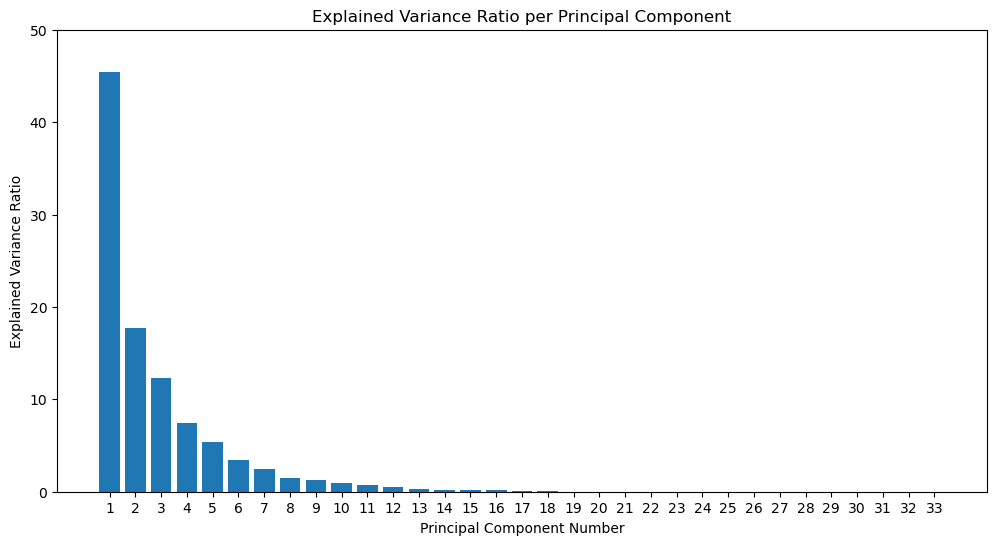

In [50]:
pca_data1, explained_variance_ratio1 = pca(merged_df1, n_comp=3)

n_components_plotted = len(explained_variance_ratio1)
component_numbers = range(1, n_components_plotted + 1) 

plt.figure(figsize=(12, 6))
plt.bar(component_numbers, explained_variance_ratio1*100)
plt.xlabel("Principal Component Number")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio per Principal Component")
plt.xticks(component_numbers) 
plt.ylim(0, 50) 
plt.show()

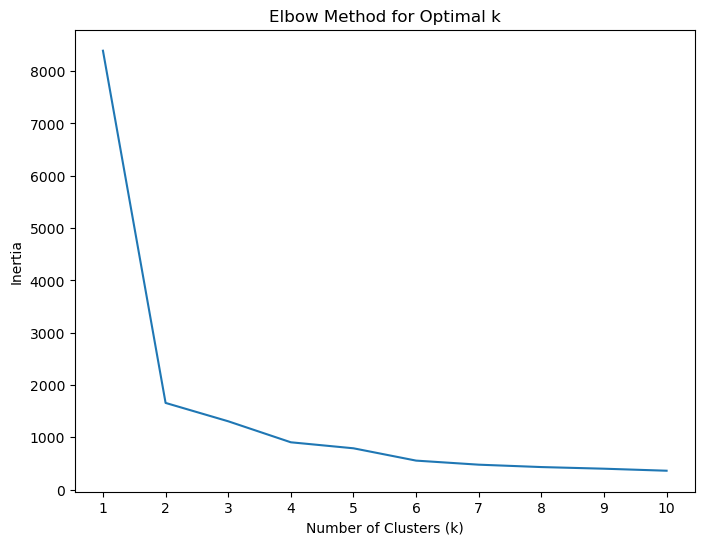

In [51]:
inertia_values = []

for k in range(1, 11): 
    labels, centroids1 = kmeans(pca_data1, k) 
    distances = np.linalg.norm(pca_data1[:, np.newaxis] - centroids1, axis=2)
    min_distances = np.min(distances, axis=1)
    inertia = np.sum(min_distances**2)
    inertia_values.append(inertia)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia_values)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.xticks(range(1, 11)) 
plt.show()

From the above graph 2 or 4 clusters is a better choice.

In [53]:
df1, centroids1 = kmeans(pca_data1, 5)

In [54]:
df["genre_numerical"], _ = pd.factorize(df["genre"])

In [55]:
adjusted_rand_index3=adjusted_rand_index(df1,df["genre_numerical"])
adjusted_rand_index3

0.39332344113535306

In [56]:
silhouette_score3=silhouette_score(pca_data1,df1)
silhouette_score3

0.49651595690603184

As we can see from above there was only a minor improvement in the metrics even after adding many more features.

So I tried once again but by considering only the most important features of of each keyword to see if there would be any improvement.

In [58]:
instrument2=instrument[["instrument","freq_min","freq_max"]]
mood2=mood[["mood","mean_timbre"]]
style2=style[["style","Tempo (BPM)_min","Tempo (BPM)_max"]]

merged_df2 = pd.merge(df, style2, on='style',how='left')
merged_df2 = pd.merge(merged_df2, mood2, on='mood',how='left')
merged_df2 = pd.merge(merged_df2, instrument2, on='instrument',how='left')

merged_df2=merged_df2.drop(["instrument","mood","genre","style"],axis=1)
merged_df2=merged_df2.set_index("song_id")

In [59]:
merged_df2

,genre_numerical,Tempo (BPM)_min,Tempo (BPM)_max,mean_timbre,freq_min,freq_max
song_id,,,,,,
74,0,80,160,0.44180,82.0,1.300
103,1,60,120,0.31900,165.0,15.000
201,2,50,110,0.44180,294.0,0.588
194,3,70,180,0.31900,20.0,20.000
184,3,40,70,0.31900,20.0,20.000
...,...,...,...,...,...,...
195,3,60,120,0.34090,20.0,20.000
7,4,160,220,0.31900,82.0,1.300
14,4,90,140,0.44180,82.0,1.300


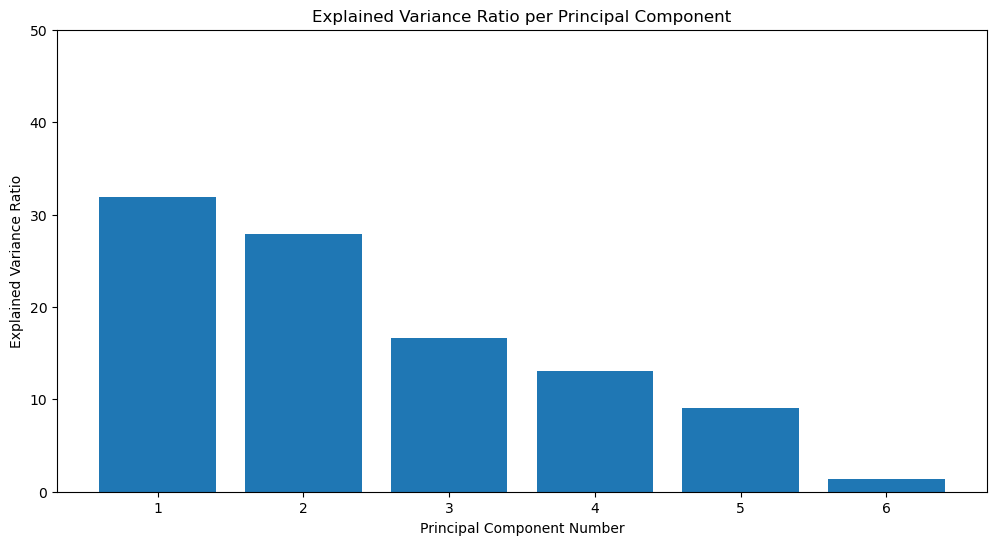

In [60]:
pca_data2, explained_variance_ratio2 = pca(merged_df2, n_comp=3)

n_components_plotted = len(explained_variance_ratio2)
component_numbers = range(1, n_components_plotted + 1) 

plt.figure(figsize=(12, 6))
plt.bar(component_numbers, explained_variance_ratio2*100)
plt.xlabel("Principal Component Number")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio per Principal Component")
plt.xticks(component_numbers) 
plt.ylim(0, 50) 
plt.show()

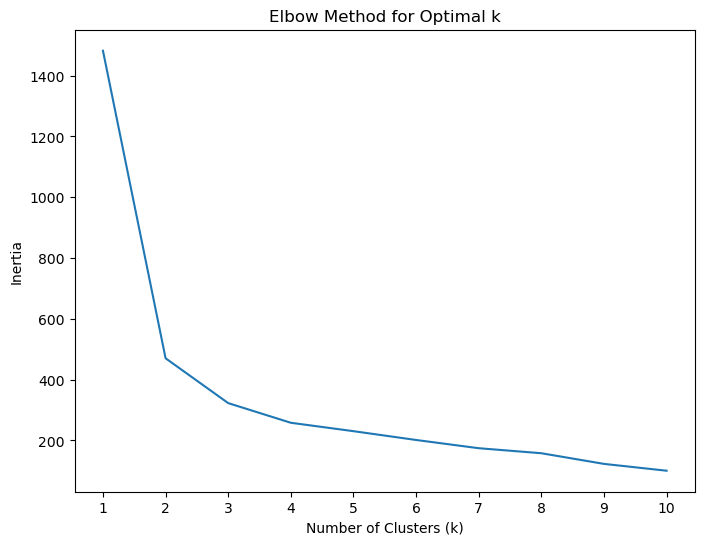

In [61]:
inertia_values = []

for k in range(1, 11): 
    labels, centroids = kmeans(pca_data2, k) 
    distances = np.linalg.norm(pca_data2[:, np.newaxis] - centroids, axis=2)
    min_distances = np.min(distances, axis=1)
    inertia = np.sum(min_distances**2)
    inertia_values.append(inertia)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia_values)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.xticks(range(1, 11)) 
plt.show()

From the above graph 2 or 3 clusters is a batter choice.

In [63]:
df2, centroids = kmeans(pca_data2, 5)
df["genre_numerical"], _ = pd.factorize(df["genre"])
adjusted_rand_index4=adjusted_rand_index(df2,df["genre_numerical"])
adjusted_rand_index4

0.32771665412795015

In [64]:
silhouette_score4=silhouette_score(pca_data2,df2)
silhouette_score4

0.30723181641927094

In [65]:
data = {'Name': ['Bow', 'TfIdf', 'added_features','most_imp_from_added'],
        'adjusted_rand_index': [adjusted_rand_index1,adjusted_rand_index2,adjusted_rand_index3,adjusted_rand_index4],
       'silhouette_score': [silhouette_score1,silhouette_score2,silhouette_score3,silhouette_score4]}
data=pd.DataFrame(data)
data

,Name,adjusted_rand_index,silhouette_score
0,Bow,0.390248,0.478583
1,TfIdf,0.390248,0.478583
2,added_features,0.393323,0.496516
3,most_imp_from_added,0.327717,0.307232


From the above table it is clear that both Bow and TfIdf have performed equally good.

TfIdf is usually better as it gives less weightage for the words that occur more frequently and gives high weightage for the rare and more important terms.But here as there are no unnecessary words i.e. no stopwords and also commonly occuring words but only 3 important words of each song Hence they both are performing equally well.

After adding many more features there was only a slight improvement in the metrics.But after removing maijority of the features and considering only the most defining features resulted in a dip in performance.Hence stating that there are other features influencing the performance.

I have plotted the elbow method graphs in each model, from this the point to consider is that 2,3 and 4 clusters prove to be better than 5 clusters.

Either ways the scores of all the models are still far from perfect i.e. far from 1 that states that there are other features rather than genre that these song are similar to.

Let's see the outputs for the best model here

In [67]:
df1=pd.DataFrame(df1)
df1=pd.concat([df1,df["genre"]],axis=1)
df1=df1.rename(columns={0: 'cluster'})

In [68]:
df1

,cluster,genre
0,3,rock
1,2,classical
2,2,country
3,0,hip-hop
4,2,hip-hop
...,...,...
142,2,hip-hop
143,3,pop
144,3,pop
145,4,pop


<Axes: xlabel='genre', ylabel='Count'>

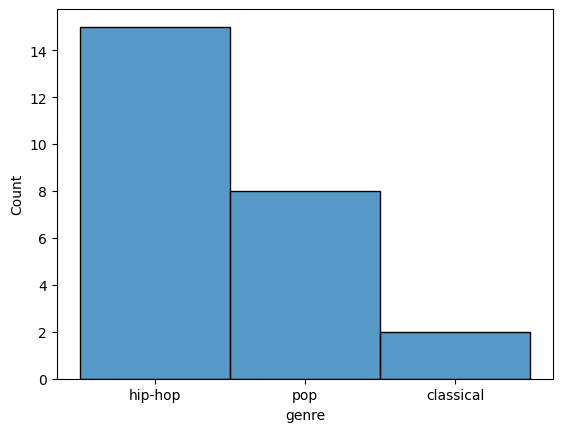

In [69]:
sns.histplot(data=df1[df1["cluster"]==0],x= "genre")

<Axes: xlabel='genre', ylabel='Count'>

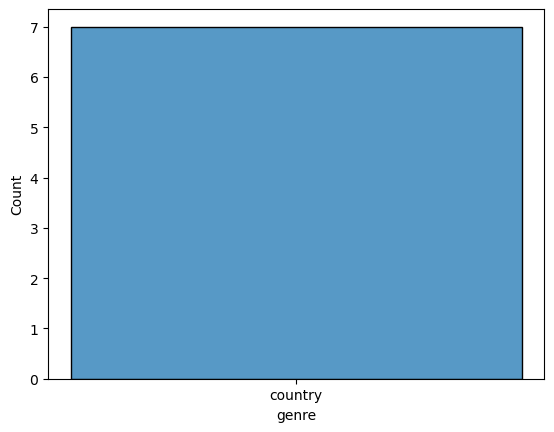

In [70]:
sns.histplot(data=df1[df1["cluster"]==1],x="genre")

<Axes: xlabel='genre', ylabel='Count'>

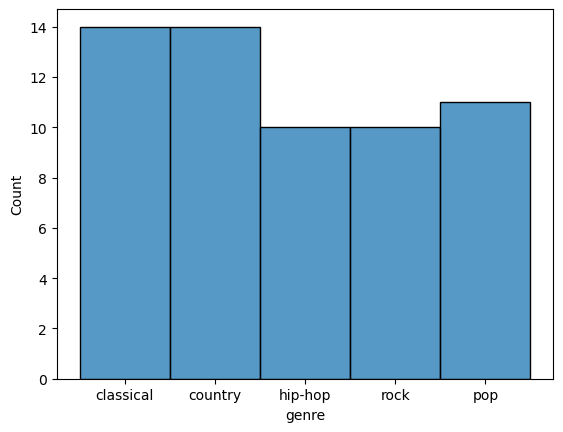

In [71]:
sns.histplot(data=df1[df1["cluster"]==2],x="genre")

<Axes: xlabel='genre', ylabel='Count'>

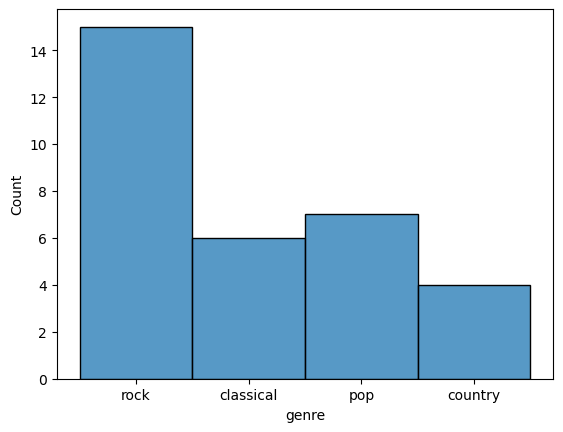

In [72]:
sns.histplot(data=df1[df1["cluster"]==3],x="genre")

<Axes: xlabel='genre', ylabel='Count'>

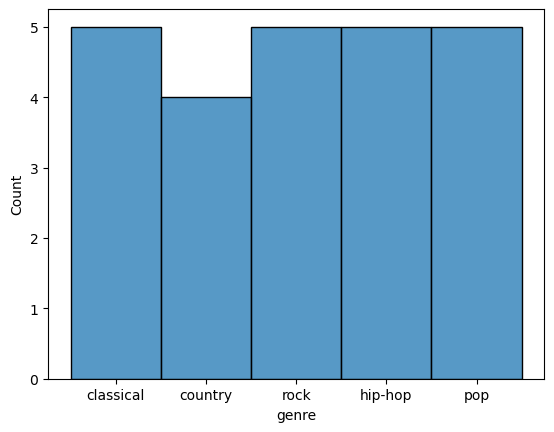

In [73]:
sns.histplot(data=df1[df1["cluster"]==4],x="genre")

Thank You for making me learn a lot

I did many supervised learning questions but not any of unsupervised learning.Here the evalualtion metrics are also quite different.Also usually I just import all the algorithms directly from sklearn,tf or torch but this time because of you guys I had to understand how they work.I also learnt that if I use unsupervised techniques before surpervised techniques in problems that are labeled I think we could get more insights in the problem.

Thank You Guys, I enjoyed making this project.